# Langgraph Coding Multiagent

* **Author:** Mitch Fehr
* **Purpose:** This coding multiagent system is designed to help you, a typical python programmer, by **explaining**, **improving**, or **debugging** your code.
  * The conditional edges of this multiagent correspond to these three tasks.

* **Current State:**
  * This is essentially the first version of this multiagent, but it seems to already work very well using the Claude Haiku 3 model.
  * Would be nice to add a tool that tests out the improved code to make sure that it works as intended.
  * Would also be good to add a confirmation agent that makes sure the output answers the initial question well. If it the agent decides it doesn't, then it goes back to the beginning.
  * Need to create a chatbot application to demo.

## Multiagent Definition

In [3]:
import os
from google.colab import userdata
from typing import Annotated, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_anthropic import ChatAnthropic
from pydantic import BaseModel, Field
from typing_extensions import TypedDict


######################################################
# LLM
######################################################
os.environ["ANTHROPIC-API-KEY"] = userdata.get("ANTHROPIC-API-KEY")

# Claude LLM -- haiku model is cheap and fast
llm = ChatAnthropic(
    model="claude-3-haiku-20240307",
    temperature=0.6,
    api_key = os.environ["ANTHROPIC-API-KEY"]
)


######################################################
# Output Classes for LLM
######################################################

# Function to extract the key information we need from the supervising LLM call
class TaskClassifier(BaseModel):
    task_type: Literal["improve", "explain", "debug"] = Field(
        ...,
        description="Classify if the message is related to code improvement, code explanation, or debugging."
    )
    code: str = Field(
        ...,
        description="This is the snippet of code that the user is referencing in their input."
    )
    error_message: str | None = Field(
        None,
        description="The error message related to the code, if one is supplied by the user."
    )

class CodeImprovements(BaseModel):
    suggestions: str = Field(
        ...,
        description="This is where the suggested code improvements (fixes) are listed in natural language and explained in detail."
    )
    improved_code: str = Field(
        ...,
        description="This is the revised code that has been improved."
    )


######################################################
# State
######################################################

# State definition -- holds all necessary info we need throughout the graph's workflow
class State(TypedDict):
    messages: Annotated[list, add_messages]
    task_type: str | None
    code: str | None
    error_message: str | None
    next_node: str | None


######################################################
# Agent Definitions
######################################################

def classify_agent(state: State):
    last_message = state["messages"][-1]
    classifier_llm = llm.with_structured_output(TaskClassifier)

    # parser = JsonOutp

    result = classifier_llm.invoke([
        {
            "role": "system",
            "content": '''You are a coding assistant. The user is going to ask a question about a certain
                code snippet, and may include an error message. Your job is to classify the user's request as
                wanting help with one of these three tasks:
                - 'improve': The user's **code works**, but they would like to **make it more efficient or
                more clear**.
                - 'explain': The **user doesn't understand the code snippet**, and would like a **detailed
                explanation**.
                - 'debug': The user's **code doesn't work**, and they would like you to **fix it** so that
                it runs and is efficient. If an error message is given, this is the intent of their request.

                After classifying the user's request, extract the code snippet and the error message, if an
                error is given.
                '''
        },
        {
            "role": "user", "content": last_message.content
        }
    ])

    return {"task_type": result.task_type, "code": result.code, "error_message": result.error_message}

def router(state: State):
    task_type = state.get("task_type", "explain") # as default, explain code
    return {"next_node": task_type}

def explain_agent(state: State):
    code = state["code"]

    result = llm.invoke([
        {
            "role": "system",
            "content": '''You are an expert Python programmer that enjoys helping out. Your job is to review this code and explain it to
                someone who has previous experience with Python, but has never seen this code before. Specifically,
                explain how the code works, line by line, as well as the overall purpose of the code and the expected
                output. Start the output with a friendly greeting.
                '''
        },
        {
            "role": "user", "content": f"Code: {code}"
        }
    ])
    return {"messages": [{"role": "assistant", "content": result.content, "name": "ExplainAgent"}]}

def improve_agent(state: State):
    code = state["code"]
    improve_llm = llm.with_structured_output(CodeImprovements)

    result = improve_llm.invoke([
        {
            "role": "system",
            "content": '''You are an expert Python programmer that enjoys helping out. Your job is to review this code, learn its structure,
                and suggest ways to improve the code. Specifically, increase its readibility, efficiency, and overall correctness.
                It is important that you do not suggest drastic changes to the code or its structure, unless drastic changes
                are completely necessary. The final output should start with a nice greeting, then include suggestions, explanations of why
                the suggestions will improve the code, and a copy of the revised code.
                '''
        },
        {
            "role": "user", "content": f"Code: {code}"
        }
    ])
    return {"messages": [{"role": "assistant", "content": result.suggestions, "name": "ImproveAgent", "additional_kwargs": {"improved_code": result.improved_code}}]}

def debug_agent(state: State):
    code = state["code"]
    error_message = state["error_message"] if state["error_message"] else "No error message provided"
    debug_llm = llm.with_structured_output(CodeImprovements)

    result = debug_llm.invoke([
        {
            "role": "system",
            "content": '''You are an expert Python programmer. The following code does not work as intended, which could mean
                that it runs into an error or incorrect output. Your job is to review this code, learn its structure and intended output,
                identify the issue, and then suggest ways to fix the problem. If you cannot locate the error, suggest ways to debug
                the current code instead. The final output should start with a nice greeting, then identify an issue (if found), list
                the proper fixes, explain why the suggestions will fix the code, and a copy of the revised code.
                '''
        },
        {
            "role": "user", "content": f"# Code: {code} \n# Error: {error_message}"
        }
    ])
    return {"messages": [{"role": "assistant", "content": result.suggestions, "name": "DebugAgent", "additional_kwargs": {"improved_code": result.improved_code}}]}


######################################################
# Multiagent Structure
######################################################

graph_builder = StateGraph(State)

# Creating the structure of the graph
graph_builder.add_node("classifier", classify_agent)
graph_builder.add_node("router", router)
graph_builder.add_node("explain", explain_agent)
graph_builder.add_node("improve", improve_agent)
graph_builder.add_node("debug", debug_agent)

graph_builder.add_edge(START, "classifier")
graph_builder.add_edge("classifier", "router")
graph_builder.add_conditional_edges(
    "router",
    lambda state: state["next_node"],
    {"explain": "explain", "improve": "improve", "debug": "debug"}
)
graph_builder.add_edge("explain", END)
graph_builder.add_edge("improve", END)
graph_builder.add_edge("debug", END)

graph = graph_builder.compile()



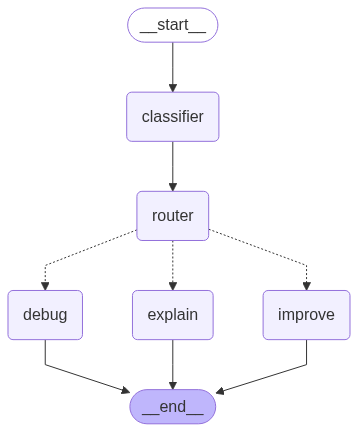

In [4]:
# Code to generate Multiagent Graph

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Test

In [5]:
input = '''How can I make this code better?

# Data for processing
d = [
    {"name": "John", "age": 21, "score": 88},
    {"name": "Jane", "age": 19, "score": 92},
    {"name": "Dave", "age": 22, "score": 76},
    {"name": "Kate"}, # Missing data
    {"name": "Peter", "age": 25, "score": 95}
]

# Process data
def proc_data(data):
    # Temp variables
    x = []
    y = 0
    z = 0

    # Loop
    for item in data:
        if "age" in item:
            if item["age"] > 20:
                x.append(item)

    # Second loop for calculation
    for item in x:
        y += item["score"]
        z += 1

    # Calculate result
    result = y / z
    return result

# Run and print
final_val = proc_data(d)
print("Final value is: " + str(final_val))

'''
state = graph.invoke({"messages": [{"role": "user", "content": input}]})

print(f'CONTENT: {state["messages"][-1].content}')
if state["messages"][-1].additional_kwargs.get("improved_code"):
    print(f'IMPROVED CODE: {state["messages"][-1].additional_kwargs["improved_code"]}')

CONTENT: Here are the suggested improvements to the code:

1. Renamed the `d` variable to `data` for better readability and clarity.
2. Renamed the `proc_data` function to `process_data` for better naming convention.
3. Added a docstring to the `process_data` function to explain its purpose, parameters, and return value.
4. Simplified the logic in the `process_data` function by using a list comprehension to filter the data for people over 20 years old, and then calculating the total score and number of people in a single loop.
5. Handled the case where there are no people over 20 years old by returning 0.0 instead of potentially dividing by zero.
6. Used an f-string to format the final value output for better readability.

These improvements make the code more readable, efficient, and robust, without changing the overall structure or functionality.
IMPROVED CODE: # Data for processing
data = [
    {"name": "John", "age": 21, "score": 88},
    {"name": "Jane", "age": 19, "score": 92},
 